## Import dependecies

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
import random
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

## CBIR Model

In [2]:
class FeatureExtractor:
    def __init__(self):
        base_model = InceptionV3(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

    def extract(self, img):
        img = img.resize((299, 299))
        img = img.convert('RGB')
        x = np.array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

In [ ]:
image_dir = "archive/Gano-Cat-Breeds-V1_1/"
output_dir = "archive/"

feature_extractor = FeatureExtractor()

# List to store features and image paths
features = []
image_paths = []
file_names = []

# Extract features for each image
for cat_breed_dir in sorted(Path(image_dir).glob('*')):
    if cat_breed_dir.is_dir():
        cat_breed_name = cat_breed_dir.name
        for img_path in sorted(cat_breed_dir.glob('*.jpg')):
            print(img_path)
            img = Image.open(img_path)
            feature = feature_extractor.extract(img)
            features.append(feature)
            image_paths.append(str(img_path))
            file_names.append(cat_breed_name + '/' + img_path.stem)

# Convert lists to numpy arrays
features = np.array(features)
image_paths = np.array(image_paths)
file_names = np.array(file_names)

# Save features and image paths to files
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, "features.npy"), features)
np.save(os.path.join(output_dir, "image_paths.npy"), image_paths)
np.save(os.path.join(output_dir, "file_names.npy"), file_names)

archive\Gano-Cat-Breeds-V1_1\Abyssinian\Abyssinian-13743713_251.jpg
1/1 [==============================] - 4s 4s/step
archive\Gano-Cat-Breeds-V1_1\Abyssinian\Abyssinian-16485182_247.jpg
1/1 [==============================] - 1s 539ms/step
archive\Gano-Cat-Breeds-V1_1\Abyssinian\Abyssinian-16734355_246.jpg
1/1 [==============================] - 1s 543ms/step
archive\Gano-Cat-Breeds-V1_1\Abyssinian\Abyssinian-17704905_241.jpg
1/1 [==============================] - 1s 632ms/step
archive\Gano-Cat-Breeds-V1_1\Abyssinian\Abyssinian-35021741_239.jpg
1/1 [==============================] - 1s 588ms/step
archive\Gano-Cat-Breeds-V1_1\Abyssinian\Abyssinian-35374431_238.jpg
1/1 [==============================] - 1s 512ms/step
archive\Gano-Cat-Breeds-V1_1\Abyssinian\Abyssinian-36865042_237.jpg
1/1 [==============================] - 1s 573ms/step
archive\Gano-Cat-Breeds-V1_1\Abyssinian\Abyssinian-37771828_235.jpg
1/1 [==============================] - 1s 603ms/step
archive\Gano-Cat-Breeds-V1_1\Abyssi

## CNN Model

In [3]:
# Specify the input and output directories
input_dir = 'archive/Gano-Cat-Breeds-V1_1/'  # Directory containing the cat breed folders
output_dir = 'archive/CNN Models/'  # Directory to save the trained model

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate the list of cat breeds from the folder names
cat_breeds = os.listdir(input_dir)

In [4]:
# Specify the input and output directories
input_dir = 'archive/Gano-Cat-Breeds-V1_1/'  # Directory containing the cat breed folders
output_dir = 'archive/CNN Models/'  # Directory to save the trained model

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate the list of cat breeds from the folder names
cat_breeds = os.listdir(input_dir)

# Define batch size and initialize lists for data and labels
batch_size = 100
data_cat = []
labels_cat = []

# Process the data in batches
for i, cat_breed in enumerate(tqdm(cat_breeds, desc='Processing cat breeds')):
    folder_path = os.path.join(input_dir, cat_breed)
    image_files = list(Path(folder_path).glob('*'))
    
    for j in tqdm(range(0, len(image_files), batch_size), desc=f'Processing {cat_breed} images', leave=False):
        batch_files = image_files[j:j+batch_size]
        batch_data = []
        for img_file in batch_files:
            img = Image.open(img_file)
            img = img.resize((299, 299))
            img = img.convert('RGB')
            img_data = np.array(img)
            batch_data.append(img_data)
            labels_cat.append(i)
        data_cat.append(batch_data)

# Convert the data and labels to NumPy arrays
data_cat = np.concatenate(data_cat)
labels_cat = np.array(labels_cat)

Processing cat breeds: 100%|██████████| 15/15 [02:18<00:00,  9.25s/it]


In [ ]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data_cat, labels_cat, test_size=0.2, random_state=42)

# Normalize the pixel values to the range [0, 1]
train_data = train_data.astype('float32') / 255
test_data = test_data.astype('float32') / 255

# Create the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add Dropout regularization with a rate of 0.5
model.add(Dense(len(cat_breeds), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels))

# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Save the model
model.save(os.path.join(output_dir, 'cat_breed_model.h5'))

## Testing CBIR-CNN Model

1/1 [==============================] - 4s 4s/step


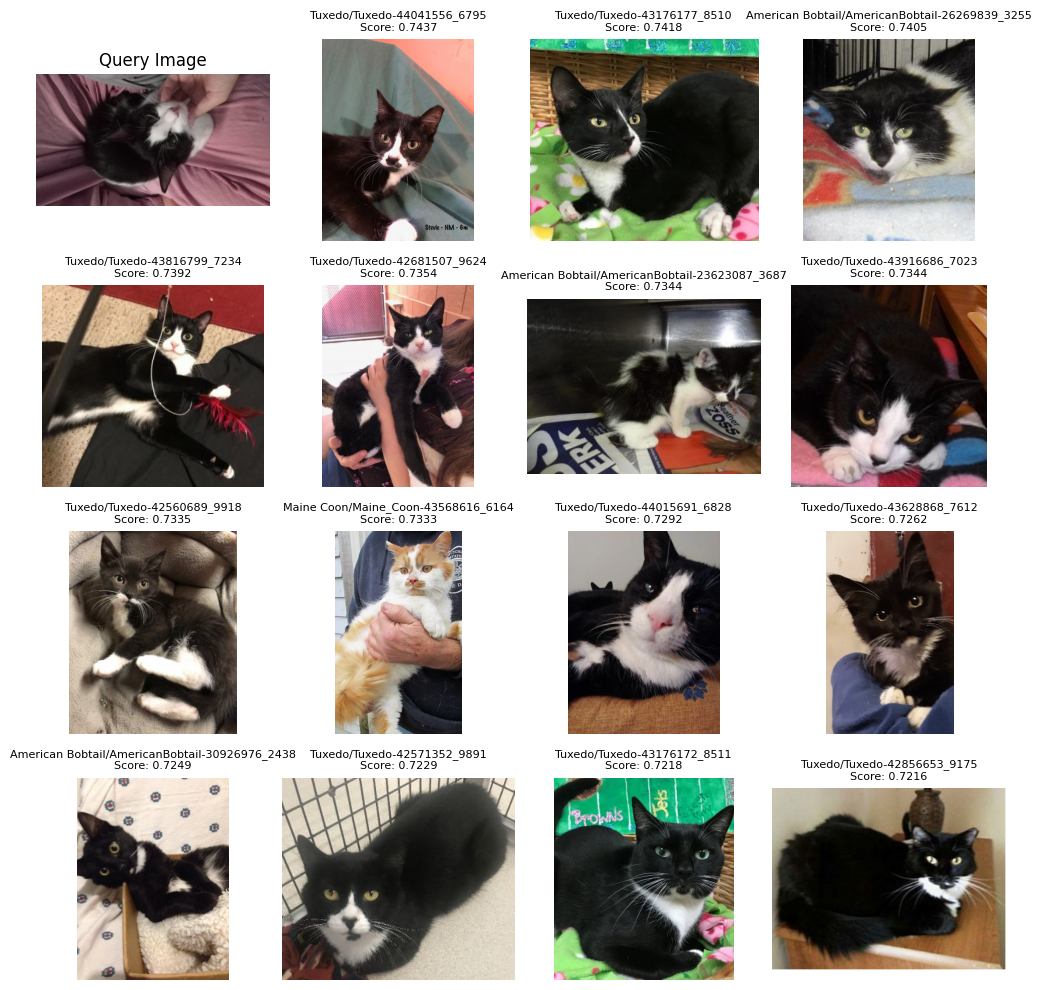

In [ ]:
# Load saved features and image paths
features = np.load("archive/features.npy")
image_paths = np.load("archive/image_paths.npy")
file_names = np.load("archive/file_names.npy")

# Path to the query data folder
query_folder = "archive/Data Test"

# Get a list of image files in the query folder
query_files = [file for file in os.listdir(query_folder) if file.endswith((".jpeg", ".jpg", ".png"))]

# Randomly select a query file
query_file = random.choice(query_files)
query_image_path = os.path.join(query_folder, query_file)

query_image = Image.open(query_image_path)

# query_image = Image.open("archive\Data Test\TesKucing (19).jpeg")

query_feature = FeatureExtractor().extract(query_image)

# Calculate distances between the query feature and all database features
dists = np.linalg.norm(features - query_feature, axis=1)

# Convert distances to similarity scores using cosine similarity
similarities = np.dot(features, query_feature) / (np.linalg.norm(features, axis=1) * np.linalg.norm(query_feature))

# Get indices of the matched images
k = 15  # Number of closest images to retrieve
indices = np.argsort(dists)[:k]
matched_images = image_paths[indices]
matched_file_names = file_names[indices]
similarities = similarities[indices]

# Display the query image and matched images with their file names
num_matched_images = len(matched_images)

num_rows = int(np.ceil((num_matched_images + 1) / 4))
fig, axes = plt.subplots(num_rows, 4, figsize=(10, 10))

# Plot query image
axes[0, 0].imshow(query_image)
axes[0, 0].set_title("Query Image")
axes[0, 0].axis('off')

# Plot matched images
for i, (image_path, file_name, score, ax) in enumerate(zip(matched_images, matched_file_names, similarities, axes.flatten()[1:])):
    img = Image.open(image_path)
    ax.imshow(img)
    ax.set_title(f"{file_name}\nScore: {score:.4f}", fontsize=8)  # Set title with smaller font size
    ax.axis('off')

# Remove empty subplots if necessary
if (num_matched_images + 1) % 4 != 0:
    for j in range((num_matched_images + 1) % 4, 4):
        axes[-1, j].axis('off')

plt.tight_layout()
plt.show()
